In [1]:
%matplotlib inline

In [212]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2

from skimage import data, img_as_float, io
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.util import random_noise


In [517]:
patch_size = 7
neighbour_dis = 21
var_image = 0.02
var_patch = 0.00
h = 2
w = cv2.getGaussianKernel(patch_size, var_patch)
w = np.dot(w, w.T)
w = np.tile(w[:, :, None], [1, 1, 3])

In [530]:
def patch_distance_2d(p1, p2, s, var, n_channels):
    DISTANCE_CUTOFF = 0.03
    tmp_diff = p1 - p2
    distance = np.sum(w * (tmp_diff * tmp_diff - var))
#     print(distance)
    if distance > DISTANCE_CUTOFF:
        return 0.
    return math.exp(-max(0.0, distance))

In [537]:

def nl_means_denoising_2d(image, s, d, h, var):
    n_row, n_col, n_channels = image.shape[0], image.shape[1], image.shape[2]
    
    A = (s - 1.) / 4.

    # add padding of s/2
    offset = s//2
    padded = cv2.copyMakeBorder(image, offset, offset, offset, offset, cv2.BORDER_REFLECT)
    print("size", padded.shape)
    
    result = np.zeros_like(image)
    
    # iterate through whole image
    for row in range(n_row):
        i_st = row - min(d, row)
        i_ed = row + min(d, n_row-row)
        print(row)
        for col in range(n_col):
            j_st = col - min(d, col)
            j_ed = col + min(d, n_col-col)
            
            current_patch = padded[row:row+s, col:col+s, :]
            sum_weight = 0
            pixel_val = np.zeros((n_channels))
            
            # neighbour patches
            for i in range(i_st, i_ed):
                for j in range(j_st, j_ed):
                    cmp_patch = padded[i:i+s, j:j+s, :]
                    weight = patch_distance_2d(current_patch, cmp_patch, patch_size, var_patch, n_channels)
                    sum_weight += weight
                    pixel_val += weight * padded[i+offset, j+offset]
            result[row, col, :] = pixel_val / sum_weight
#             print(result)
            
    return np.squeeze(np.asarray(result))

(225, 225, 3)


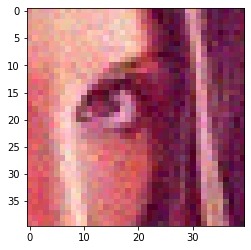

In [538]:
image = img_as_float(io.imread('lena.jpg'))
print(image.shape)
image = image[100:140, 130:170]
sigma = 0.04
noisy = random_noise(image, var=sigma**2)
plt.imshow(noisy)

size (46, 46, 3)


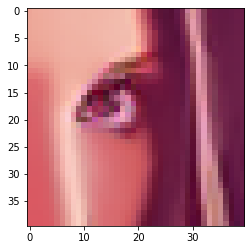

In [539]:
denoised = nl_means_denoising_2d(noisy, patch_size, neighbour_dis, 2, 0)
plt.imshow(denoised)

In [540]:
def psnr(A, B):
    return 10*np.log(255*255.0/(((255*(A-B))**2).mean()))/np.log(10)

In [541]:
print(psnr(image, denoised))

30.316066714172834
